# County of Riverside: Assessed Property Values

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import squarify 

%matplotlib inline
sns.set_theme(style='darkgrid')
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Objective

To better understand the valuations and composition of the different property types under assessment subject to taxation as per the California Revenue & Taxation Code. As an public servant working in the County of Riverside Auditor-Controller's Office, these values are provided by the County Assesseor and subsequently used in the calculation of taxes. As these values are a vital component of the tax calculation process, a fundamental understanding of the assessment/roll types will be greatly beneficial. 

## About the Dataset
This dataset consists of tax-roll values by Tax Authority Group (TAG) and is made publicly available in Excel format by the County of Riverside Auditor-Controller's Office on their [portal](https://ca-riverside-aco.publicaccessnow.com/PropertyTaxInformation/AssessedValues/FiscalYear22-23.aspx).

## Importing the Dataset
The raw data will be found in the second sheet of the excel file, the first 6 rows comprise a header and the last 29 rows comprise a summary section. These will be omitted from the data import:

In [2]:
# Import data from sheet 2, skip first 6 rows, last 29 rows 
df_raw = pd.read_excel('FY 22-23 Preliminary Roll Valuation.xlsx', sheet_name=1, skiprows=5, skipfooter = 29)
# preview
df_raw.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,TAG:,001-000 BANNING ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Value Type,Secured Roll,SBE Roll,NaN,NaN,NaN,Combined Secured\n& SBE,Unsecured Roll\nNo Aircraft,Unsecured Roll\nAircraft Only,NaN,NaN,Total Roll No Aircraft,NaN,Total All Rolls
2,LAND,186579208,0,NaN,NaN,NaN,186579208,0,0,NaN,NaN,186579208,NaN,186579208
3,STRUCTURES,630631934,0,NaN,NaN,NaN,630631934,0,0,NaN,NaN,630631934,NaN,630631934
4,FIXTURES,2614157,0,NaN,NaN,NaN,2614157,2279523,0,NaN,NaN,4893680,NaN,4893680
5,PERSONAL PROPERTY,2370527,0,NaN,NaN,NaN,2370527,4653271,0,NaN,NaN,7023798,NaN,7023798
6,PENALTY,0,0,NaN,NaN,NaN,0,1270,0,NaN,NaN,1270,NaN,1270
7,GROSS VALUE,822195826,0,NaN,NaN,NaN,822195826,6934064,0,NaN,NaN,829129890,NaN,829129890
8,-EXEMPTIONS,33988793,0,NaN,NaN,NaN,33988793,26464,0,NaN,NaN,34015257,NaN,34015257
9,TAXABLE NET,788207033,0,NaN,NaN,NaN,788207033,6907600,0,NaN,NaN,795114633,NaN,795114633


As seen above, the data consists of multiple sub-tables for each Tax Authority Group (TAG): See lines 0 and 14 are the headers for the TAG group and the subsequent lines are the data for that TAG. This layout, while simple to follow when viewing file in Excel or other spreadsheet software, makes it difficult to analyze the dataset as a whole (imagine filtering/subtotaling by TAG value  and any given attributes etc) and as such, this data needs to be synthesized into a more cohesive table to better prepare for analysis.

## Data Cleaning & Transformation

In [3]:
# Check df info to identify any other potential problem areas
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39029 entries, 0 to 39028
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   35589 non-null  object 
 1   Unnamed: 1   32149 non-null  object 
 2   Unnamed: 2   28709 non-null  object 
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64
 5   Unnamed: 5   0 non-null      float64
 6   Unnamed: 6   28709 non-null  object 
 7   Unnamed: 7   28709 non-null  object 
 8   Unnamed: 8   28709 non-null  object 
 9   Unnamed: 9   0 non-null      float64
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  28709 non-null  object 
 12  Unnamed: 12  0 non-null      float64
 13  Unnamed: 13  32149 non-null  object 
dtypes: float64(6), object(8)
memory usage: 4.2+ MB


Looking at the dataframe info, due to the file being provided in excel format and presumably being designed to be printable/human-legible, there are alot of empty columns and rows. For example: Columns 3-5, 9-10, and 12 are entirely null values. These unecessary rows and columns will be dropped.

In [4]:
df_raw = df_raw.loc[:,df_raw.notna().any(axis=0)] # drop columns comprised entirely of null values
df_raw = df_raw.dropna(axis = 0, how = 'all') # also drop rows comprised entirely of null values

Next, add column names using one of the header rows as a reference:

In [5]:
col_names = df_raw.loc[1].tolist()
col_names

['Value Type',
 'Secured Roll',
 'SBE Roll',
 'Combined Secured\n& SBE',
 'Unsecured Roll\nNo Aircraft',
 'Unsecured Roll\nAircraft Only',
 'Total Roll No Aircraft',
 'Total All Rolls']

In [6]:
# Clean column names by removing spaces and line separators
colnames_cleaned = []
for i in col_names:
    name = i.replace(' ','').replace('\n','')
    colnames_cleaned.append(name)
colnames_cleaned

['ValueType',
 'SecuredRoll',
 'SBERoll',
 'CombinedSecured&SBE',
 'UnsecuredRollNoAircraft',
 'UnsecuredRollAircraftOnly',
 'TotalRollNoAircraft',
 'TotalAllRolls']

The cleaned up column names will be assigned back to the dataframe. Additionally, all subsequent "header" rows in the dataset will be removed.

In [7]:
# Assign cleaned column names to dataframe
df_raw.columns = colnames_cleaned
# Now that we have column names, remove all subsequent "header" rows from data 
df_raw = df_raw[df_raw['ValueType']!='Value Type']
# Preview
df_raw.head()

,ValueType,SecuredRoll,SBERoll,CombinedSecured&SBE,UnsecuredRollNoAircraft,UnsecuredRollAircraftOnly,TotalRollNoAircraft,TotalAllRolls
0,TAG:,001-000 BANNING ...,NaN,NaN,NaN,NaN,NaN,NaN
2,LAND,186579208,0,186579208,0,0,186579208,186579208
3,STRUCTURES,630631934,0,630631934,0,0,630631934,630631934
4,FIXTURES,2614157,0,2614157,2279523,0,4893680,4893680
5,PERSONAL PROPERTY,2370527,0,2370527,4653271,0,7023798,7023798


Now that the raw data has been cleaned up somewhat, a for loop will be used to iterate over the raw data to identify TAG Number, TAG Description, and pull all the values and assign them to a list to later convert to a dataframe. PIN COUNT row will be dropped. Rows containing subtotals: 'GROSS VALUE', 'TAXABLE NET', 'ADJUSTED NET' will be omitted. These values can be inferred later if need be.

In [8]:
data_list = [] # will contain lists of values (each list corresponding to a row)
skip_rows = ['GROSS VALUE', 'TAXABLE NET', 'ADJUSTED NET', 'PIN COUNT'] # rows containing unneeded values
# begin iteration
for index, row in df_raw.iterrows():
    val_type = row['ValueType']
    val_type = re.sub('[^A-Z\s]','',val_type) # allow only for alphanum chars & whitespace
    val_type = val_type.strip()
    # If row is a TAG header row then extract identifying information
    if val_type == 'TAG':
        # Identify TAG 
        tag = row['SecuredRoll'].strip() # remove trailing / leading whitespace characters
        tag = re.sub('\s+',' ',tag) # replace consecutive space characters with single space
        # separate TAG code from TAG Description
        tag_num = tag.split(' ')[0]
        tag_desc = ' '.join(tag.split(' ')[1:])
        # some TAG descriptions have a year (sometimes preceded by dash) at the end of string
        # We will remove extranous characters to clean it up (ex: "MORENO VALEY - 2021" -> "MORENO VALLEY") 
        tag_desc = re.sub('[^A-Z]+$','',tag_desc).strip()
    # Otherwise, row is a data row, if row is not pin count row, pull all values from row into list and add this list to data_list
    else:
        if val_type == 'EXEMPTIONS': # convert values to negative
            data_list.append([
                tag_num,
                tag_desc,
                val_type,
                row['SecuredRoll']*-1,
                row['SBERoll']*-1,
                row['CombinedSecured&SBE']*-1,
                row['UnsecuredRollNoAircraft']*-1,
                row['UnsecuredRollAircraftOnly']*-1,
                row['TotalRollNoAircraft']*-1,
                row['TotalAllRolls']*-1
            ])            
        elif val_type not in skip_rows:
            data_list.append([
                tag_num,
                tag_desc,
                val_type,
                row['SecuredRoll'],
                row['SBERoll'],
                row['CombinedSecured&SBE'],
                row['UnsecuredRollNoAircraft'],
                row['UnsecuredRollAircraftOnly'],
                row['TotalRollNoAircraft'],
                row['TotalAllRolls']
            ])

In [9]:
# create the TAG dataframe from list of lists created in step above
df = pd.DataFrame(data_list, columns = ['TAGNum', 'TAGDesc'] + colnames_cleaned)
# Preview
df.head()

,TAGNum,TAGDesc,ValueType,SecuredRoll,SBERoll,CombinedSecured&SBE,UnsecuredRollNoAircraft,UnsecuredRollAircraftOnly,TotalRollNoAircraft,TotalAllRolls
0,001-000,BANNING,LAND,186579208,0,186579208,0,0,186579208,186579208
1,001-000,BANNING,STRUCTURES,630631934,0,630631934,0,0,630631934,630631934
2,001-000,BANNING,FIXTURES,2614157,0,2614157,2279523,0,4893680,4893680
3,001-000,BANNING,PERSONAL PROPERTY,2370527,0,2370527,4653271,0,7023798,7023798
4,001-000,BANNING,PENALTY,0,0,0,1270,0,1270,1270


## Creating an Import Function
Taking what we've learned above, I will re-tool the code into a custom function to import multiple files for multiple years. In addition, the function will add a new column: "FY" to denote which fiscal year the records pertain to. The fiscal year will be obtained from the filename as it denotes which fiscal year the data is for.

In [10]:
def import_data(filepath):
    '''
    PURPOSE: Will take xlsx filepath as argument and import CSV files to transform the data into a more suitable format for analysis
    '''
    df_raw = pd.read_excel(filepath, sheet_name=1, skiprows=5, skipfooter = 29)
    df_raw = df_raw.loc[:,df_raw.notna().any(axis=0)] # drop columns comprised entirely of null values
    df_raw = df_raw.dropna(axis = 0, how = 'all') # also drop rows comprised entirely of null values
    col_names = df_raw.loc[1].tolist()
    colnames_cleaned = []
    for i in col_names:
        name = i.replace(' ','').replace('\n','')
        colnames_cleaned.append(name)
    df_raw.columns = colnames_cleaned # Assign cleaned column names to header
    df_raw = df_raw[df_raw['ValueType']!='Value Type'] # Now that we have column names, omit sub-header rows from data 
    
    # prepare for data iteration
    data_list = [] # will contain lists of values (each list corresponding to a row)
    skip_rows = ['GROSS VALUE', 'TAXABLE NET', 'ADJUSTED NET', 'PIN COUNT'] # rows containing unneeded values
    # begin iteration
    for index, row in df_raw.iterrows():
        val_type = row['ValueType']
        val_type = re.sub('[^A-Z\s]','',val_type) # allow only for alphanum chars & whitespace
        val_type = val_type.strip()
        # If row is a TAG header row then extract identifying information
        if val_type == 'TAG':
            # Identify TAG 
            tag = row['SecuredRoll'].strip() # remove trailing / leading whitespace characters
            tag = re.sub('\s+',' ',tag) # replace consecutive space characters with single space
            # separate TAG code from TAG Description
            tag_num = tag.split(' ')[0]
            tag_desc = ' '.join(tag.split(' ')[1:])
            # some TAG descriptions have a year (sometimes preceded by dash) at the end of string
            # We will remove extranous characters to clean it up (ex: "MORENO VALEY - 2021" -> "MORENO VALLEY") 
            tag_desc = re.sub('[^A-Z]+$','',tag_desc).strip()
        # Otherwise, row is a data row, if row is not pin count row, pull all values from row into list and add this list to data_list
        else:
            if val_type == 'EXEMPTIONS': # convert values to negative
                data_list.append([
                    tag_num,
                    tag_desc,
                    val_type,
                    row['SecuredRoll']*-1,
                    row['SBERoll']*-1,
                    row['CombinedSecured&SBE']*-1,
                    row['UnsecuredRollNoAircraft']*-1,
                    row['UnsecuredRollAircraftOnly']*-1,
                    row['TotalRollNoAircraft']*-1,
                    row['TotalAllRolls']*-1
                ])            
            elif val_type not in skip_rows:
                data_list.append([
                    tag_num,
                    tag_desc,
                    val_type,
                    row['SecuredRoll'],
                    row['SBERoll'],
                    row['CombinedSecured&SBE'],
                    row['UnsecuredRollNoAircraft'],
                    row['UnsecuredRollAircraftOnly'],
                    row['TotalRollNoAircraft'],
                    row['TotalAllRolls']
                ])

    # create the TAG dataframe from list of lists created in step above
    df = pd.DataFrame(data_list, columns = ['TAGNum', 'TAGDesc'] + colnames_cleaned)
    
    # Add a column with fiscal year (retrieved from filename using regex, yr will be in YY-YY format)
    fy = re.search(r"\d{2}-\d{2}", filepath).group(0)
    fy = f"20{fy.split('-')[0]}-20{fy.split('-')[1]}" # change to YYYY-YYYY format
    df['FY'] = fy # assign FY value to column
    df = df[['FY'] + [col for col in df.columns if col != 'FY']] # Move FY column to the front

    return df # Return the dataframe

Using the function to import files into 3 seperate dataframes:

In [11]:
# import files using function
df1= import_data('FY 19-20 Preliminary Roll Valuation.xlsx')
df2= import_data('FY 20-21 Preliminary Roll Valuation.xlsx')
df3= import_data('FY 22-23 Preliminary Roll Valuation.xlsx')

Concatenate all rows from the imported data for all fiscal years into one dataframe:

In [12]:
df_combined = pd.concat([df1,df2,df3], axis=0, ignore_index=True)

## Analyzing the Data

### Total Assessed Values by Fiscal year

In [13]:
df_fy = df_combined.groupby('FY').sum().reset_index()

Visualizing total growth in assessed values by fiscal year:

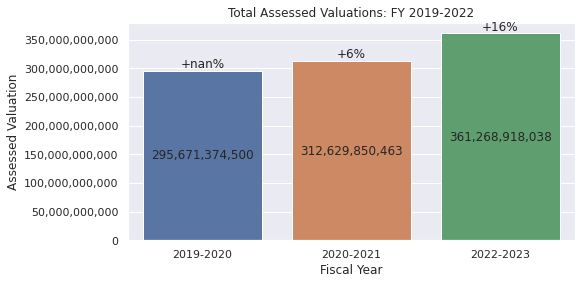

In [14]:
fig = plt.figure(figsize=(8,4)) # set size of chart

# plotting parameters
ax = sns.barplot(x = 'FY',
            y = 'TotalAllRolls',
            data = df_fy)

# add chart labels
ax.set(xlabel='Fiscal Year', ylabel='Assessed Valuation', title = 'Total Assessed Valuations: FY 2019-2022')
for container in ax.containers: # total value in dollars
    ax.bar_label(container, label_type='center', labels=[f'{x:,.0f}' for x in container.datavalues])
for container in ax.containers: # % change
    ax.bar_label(container, labels=[f'+{x:,.0%}' for x in df_fy['TotalAllRolls'].pct_change().reset_index()['TotalAllRolls']])

# Add comma separators to y axis tick labels
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show() # display chart

In grouping ALL assessed values for the three fiscal years for which we have data for, when compared to prior year, total assessed valuations for the county increased 6% in the 2020-2021 fiscal year and 16% in the 2022-2023 fiscal year.

### Total Assessed Values by Fiscal year and Property Type

In [15]:
# New dataframe grouped by fiscal year
df_VT = df_combined.groupby(['FY','ValueType']).sum().reset_index()

# Transform to show fiscal years as columns
df_VT = pd.pivot_table(
    df_VT, values='TotalAllRolls', index=['ValueType'], 
    columns = 'FY', aggfunc=np.sum).reset_index().dropna()#fillna(0)

# Add a percentage change column
df_VT['3YrPctChange'] = ((df_VT['2022-2023']-df_VT['2019-2020'])/df_VT['2019-2020'])*100

df_VT.sort_values(by=['3YrPctChange'], ascending=False) # Display dataframe

FY,ValueType,2019-2020,2020-2021,2022-2023,3YrPctChange
1,FIXTURES,4838727652,5116887751,6350109667,31.24
7,STRUCTURES,204715085081,218488251405,255852121787,24.98
6,PERSONAL PROPERTY,5822217745,6031234114,6701930997,15.11
3,LAND,87442944767,90595079458,100526076186,14.96
0,EXEMPTIONS,-9354329428,-9765355372,-10285250022,9.95
4,LIVING IMPROVMENTS,81952960,80506764,84537023,3.15
2,HO EXEM,2013806617,1982994001,1935703938,-3.88
5,PENALTY,110969106,100252342,103688462,-6.56


Of the different assessment types, assessments for fixtures and structures increased the most over this three year span, having increased 31% and 25% respectively.

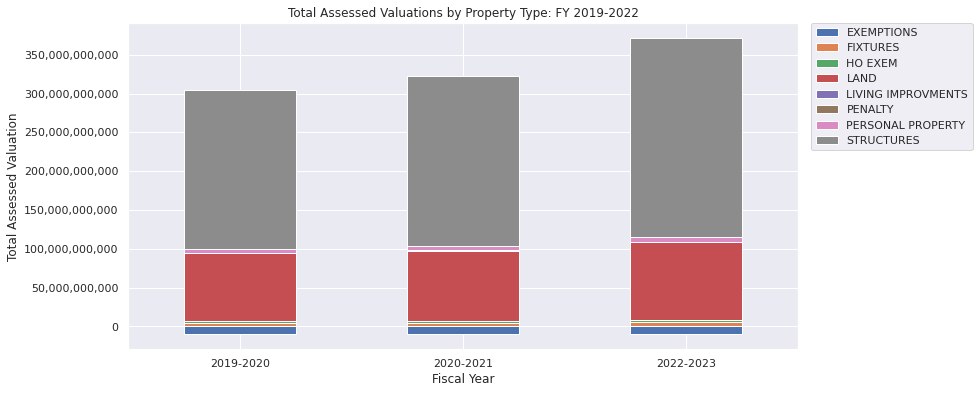

In [16]:
# Re-shape data
df_VT = df_combined.groupby(['FY','ValueType']).sum().reset_index()
df_VT = pd.pivot_table(
    df_VT, values='TotalAllRolls', index=['FY'], 
    columns = 'ValueType', aggfunc=np.sum).reset_index().rename_axis(None, axis=1).dropna()#fillna(0)

# Create chart
ax = df_VT.set_index('FY').plot(kind='bar', stacked=True)
ax.set(xlabel='Fiscal Year', ylabel='Total Assessed Valuation', title = 'Total Assessed Valuations by Property Type: FY 2019-2022')
ax.tick_params(axis='x', rotation=0)

# Chart legend & size configuration
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.gcf().set_size_inches(12, 6)

# Add comma separators to y axis tick labels
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show() # Display chart

As depicted in above stacked bar chart, of the various assessment value types, two stand out in the majority: Structures and land. Averaging the assessment totals for these three given years:
- **Structures** account for 70% of total assessment valuation
- **Land** account for 28% of total assessment valuation

The remaining assessment valuation types are comparatively small.

### Total Assessed Values by Fiscal Year and Roll Type

The County Assessor generally classifies assessments as **secured** or **unsecured**. 
- **Secured**: Property permanaently affixed to land (buildings, land)
- **Unsecured**: Property not permanently affixed to land (mobile homes, aircraft, boats, business personal property)

With this in mind, we can evaluate how much of the annual assessed values are secured and how much are unsecured by grouping the data by fiscal year:

In [17]:
# Group data by Roll type:
df_roll = df_combined.groupby(['FY']).sum().reset_index()
df_roll

,FY,SecuredRoll,SBERoll,CombinedSecured&SBE,UnsecuredRollNoAircraft,UnsecuredRollAircraftOnly,TotalRollNoAircraft,TotalAllRolls
0,2019-2020,286624324573,0,286624324573,8910995474,136054453,295535320047,295671374500
1,2020-2021,303184565008,0,303184565008,9276609523,168675932,312461174531,312629850463
2,2022-2023,350114585439,0,350114585439,10956781778,197550821,361071367217,361268918038


Upon grouping the data, we can see there are some uneccessary/redundant columns. for example, **SBERoll** column is 0, which also makes the **CombinedSecured&SBE** column unnecessary. The Unsecured roll is split between aircraft and non-aircraft properties, for the purposes of this analysis, we are just interested in unsecured property as a whole so we will combine them into one column. What we should have left is a compact dataframe with a column for **SecuredRoll** and another column for **UnsecuredRoll**.

In [18]:
# Sum Unsecured roll types into one column
df_roll['UnsecuredRoll'] = df_roll['UnsecuredRollNoAircraft'] + df_roll['UnsecuredRollAircraftOnly']

# Dropping unnecessary columns
df_roll = df_roll.drop(
    columns=[
        'SBERoll', 
        'CombinedSecured&SBE',
        'TotalRollNoAircraft',
        'TotalAllRolls', 
        'UnsecuredRollNoAircraft', 
        'UnsecuredRollAircraftOnly'])
df_roll

,FY,SecuredRoll,UnsecuredRoll
0,2019-2020,286624324573,9047049927
1,2020-2021,303184565008,9445285455
2,2022-2023,350114585439,11154332599


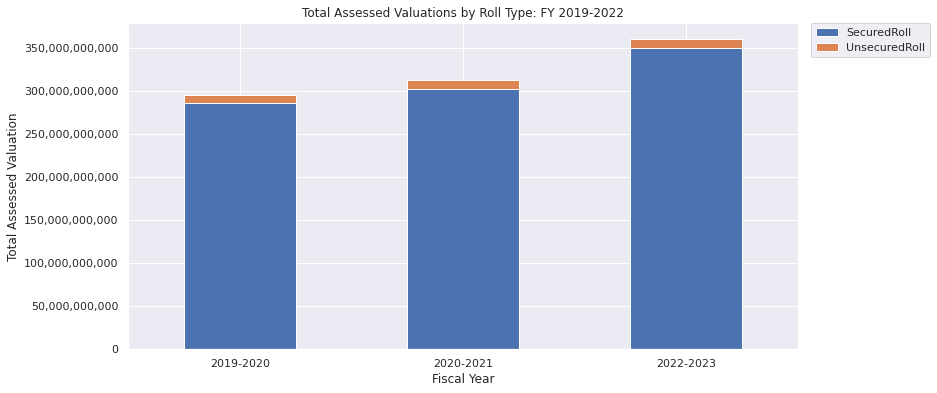

In [19]:
# Create chart
ax = df_roll.set_index('FY').plot(kind='bar', stacked=True)
ax.set(xlabel='Fiscal Year', ylabel='Total Assessed Valuation', title = 'Total Assessed Valuations by Roll Type: FY 2019-2022')
ax.tick_params(axis='x', rotation=0)

# Chart label & size configuration
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.gcf().set_size_inches(12, 6)

# Add comma separators to y axis tick labels
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show() # Display chart

Based on above figures we can immediately see that the secured roll makes up the overwhelming majority of the county's total assessment.

### Areas With Greatest Change In Assessed Property Values:

While the total roll has been increasing year over year, it will be interesting to see which specific areas (cities and districts) have been leading the growth. This section will identify the county's highest growth areas.

We will start by grouping the assessed values data by TAG Number and then transposing the results to show fiscal year as columns:

In [20]:
# Group by fiscal year, TAG and sum
df_tag = df_combined.groupby(['FY','TAGNum']).sum().reset_index()

# Transform to show annual totals as columns
df_tag = pd.pivot_table(
    df_tag, values='TotalAllRolls', index=['TAGNum'], 
    columns = 'FY', aggfunc=np.sum).reset_index().rename_axis(None, axis=1).fillna(0)#.dropna()

df_tag.head() # Preview the dataframe

,TAGNum,2019-2020,2020-2021,2022-2023
0,001-000,677779760.00,713648989.00,806834033.00
1,001-001,98362477.00,104582838.00,178201406.00
2,001-002,22559968.00,24232588.00,25861550.00
3,001-003,17128200.00,18036609.00,19478210.00
4,001-004,117673950.00,119218970.00,196117955.00


Unfortunately the TAG Descriptions in the datset are rather are messy and inconsistent as it seems they were input manually into the system that generated our dataset. It would be easier to recreate using data provided by the Riverside ACO. 
An index of primary TAG Numbers (the first part of full TAG number denoting the specific area) and their corresponding city or district can found in the document labeled **Primary Tax Rate Area Number and Names** at the following link:

https://www.auditorcontroller.org/Divisions/PropertyTaxDivision/TaxRateBook.aspx

Using this information found online, a dictionary of primary TAG numbers was created (note that school districts are those names ending in "USD" (Unified School District):

In [21]:
TAG_dict = {
    '1': 'Banning',
    '10': 'San Jacinto',
    '11': 'Palm Springs',
    '12': 'Coachella',
    '13': 'Temecula',
    '14': 'Desert Hot Springs',
    '15': 'Norco',
    '16': 'Indian Wells',
    '17': 'Rancho Mirage',
    '18': 'Palm Desert',
    '19': 'Cathedral',
    '2': 'Beaumont',
    '20': 'La Quinta',
    '21': 'Moreno Valley',
    '22': 'Calimesa',
    '23': 'Canyon Lake',
    '24': 'Murrieta',
    '25': 'Wildomar',
    '26': 'Menifee Valley',
    '27': 'Eastvale',
    '28': 'Jurupa Valley',
    '3': 'Blythe',
    '4': 'Corona',
    '5': 'Lake Elsinore',
    '6': 'Hemet',
    '7': 'Indio',
    '8': 'Perris',
    '9': 'Riverside',
    '53': 'Alvord USD',
    '54': 'Menifee Union USD',
    '55': 'Banning USD',
    '56': 'Beaumont USD',
    '58': 'Coachella USD',
    '59': 'Corona-Norco USD',
    '61': 'Palm Springs USD',
    '62': 'Desert Center USD',
    '65': 'Lake Elsinore USD',
    '68': 'Colton JT USD',
    '71': 'Hemet USD',
    '75': 'Desert Sands USD',
    '80': 'Moreno Valley USD',
    '82': 'Murrieta Valley USD',
    '83': 'Nuview Union USD',
    '85': 'Palo Verde USD',
    '87': 'Perris Union USD',
    '88': 'Riverside USD',
    '89': 'Romoland Elem USD',
    '91': 'San Jacinto USD',
    '94': 'Temecula Valley USD',
    '97': 'Yucaipa JT USD',
    '98': 'Val Verde USD'
}

Now that a dictionary has been defined, some additional modifications to the dataframe will be made to be able to use the dictionary to map the primary TAG number to the TAG number in the data for each record. 

This will be accomplished by splitting the values in **TAGNum** on the "-" charcter leaving us with the primary TAG number and the district TAG number. The leading zeros will then be stripped from the primary TAG number and resulting value will be ready to be mapped to the dictionary to populate a new column containing the relevent city name:

In [22]:
# Split TAGNum into city and district componenets
df_tag[['TAGCity','TAGDist']] = df_tag['TAGNum'].str.split('-', expand=True)
df_tag['TAGCity'] = pd.to_numeric(df_tag['TAGCity']) # Change valuetype to numeric to get rid of leading zeros
df_tag['TAGCity'] = df_tag['TAGCity'].astype("string") # Change back to string

Mapping the **TAGCity** column to the **tag_dict** dictionary should give us the dataframe with a new column **CityName** populated with the City of corrresponding TAG Number:

In [23]:
# Use dict to add new column with City or School District Name
df_tag['CityName'] = df_tag['TAGCity'].map(TAG_dict)

# Group by newly created city column
df_area = df_tag.groupby(['CityName']).sum().reset_index()
# Add new column showing % change from 2019 thru 2022 fiscal years
df_area['3YrPctChange'] = ((df_area['2022-2023']-df_area['2019-2020'])/df_area['2019-2020'])*100

# School districts sorted by growth
df_usd = df_area[df_area['CityName'].str.contains('USD')] # Filter school districts (contain USD in name)
df_usd.sort_values(by=['3YrPctChange'], ascending=False) # Display sorted results

# Cities sorted by growth
df_cities = df_area[~df_area['CityName'].str.contains('USD')] # Filter cities (do NOT contain USD in name)
df_cities.sort_values(by=['3YrPctChange'], ascending=False) # Display sorted results

,CityName,2019-2020,2020-2021,2022-2023,3YrPctChange
6,Calimesa,972843837.00,1119904505.00,1440937260.00,48.12
38,Perris,6861129044.00,7566897344.00,9590358429.00,39.78
3,Beaumont,5280237842.00,6021573517.00,7330818508.00,38.84
27,Menifee Valley,10382737583.00,11270984052.00,14037324073.00,35.20
15,Desert Hot Springs,1906767617.00,2078910359.00,2564389856.00,34.49
1,Banning,2342793976.00,2440872402.00,2995209678.00,27.85
44,San Jacinto,3270139359.00,3475597759.00,4092157570.00,25.14
35,Palm Springs,13760154597.00,14466372015.00,17140798723.00,24.57
8,Cathedral,4785074515.00,5062361987.00,5907291033.00,23.45
32,Norco,3524936985.00,3703561281.00,4311823989.00,22.32


### 2022-2023 Assessed Valuations by City and School District

#### City & District Total Tax Roll Valuations

/tmp/ipykernel_2671/1725567991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ChartLabel'] = df['CityName'] + ' $' + (df['2022-2023']/1000000000).round(1).astype(str) + 'bn'


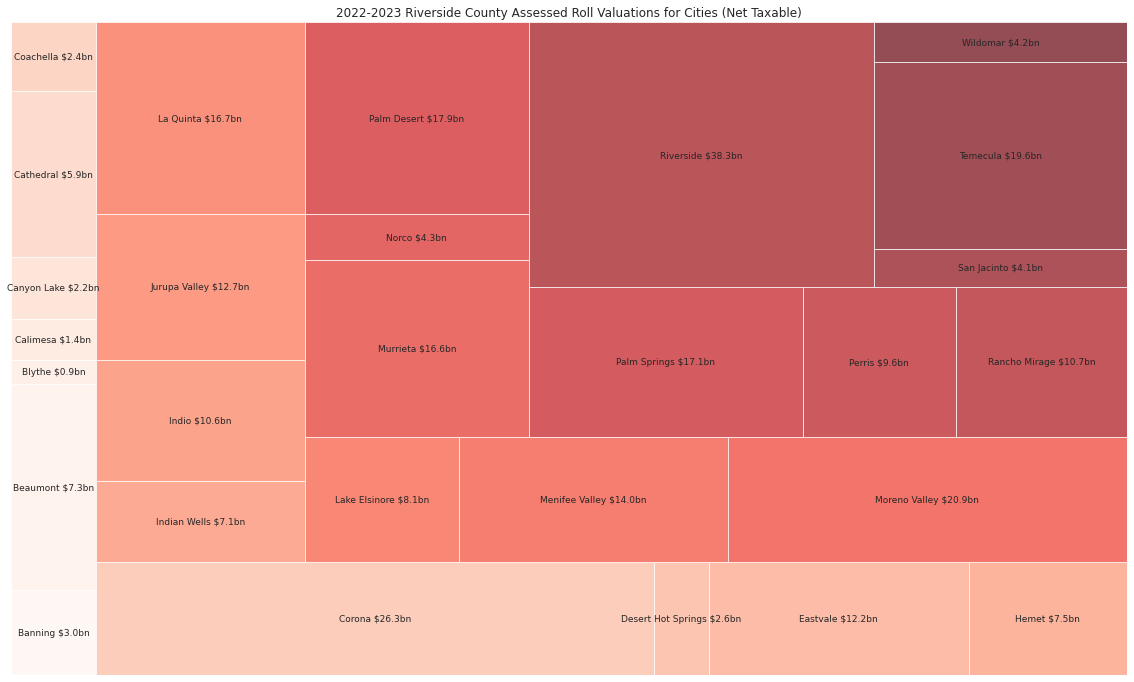

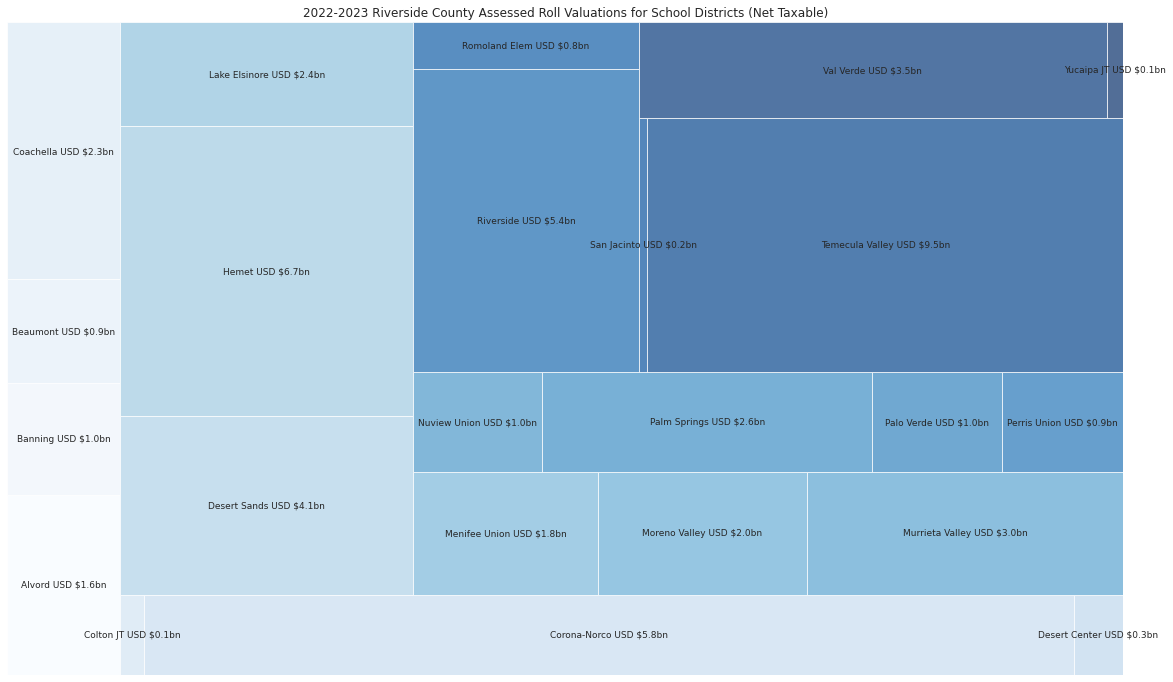

In [24]:
# List of lists of identifying info to create treemap chart
j = [
    [df_cities, matplotlib.cm.Reds, 'Cities'],
    [df_usd, matplotlib.cm.Blues, 'School Districts']
    ]

for i in j: # Iterate through list
    df = i[0] # Assign dataframe (1st elem in (list)
    # Create a column to use as label in chart
    df['ChartLabel'] = df['CityName'] + ' $' + (df['2022-2023']/1000000000).round(1).astype(str) + 'bn'
    
    # Prepare and plot Treemap - Source: https://www.python-graph-gallery.com/202-treemap-with-colors-mapped-on-values
    my_values=[i for i in range(1,df.shape[0]+1)] # Create a color palette
    cmap = i[1] # Assign color profile (2nd item in list)
    norm = matplotlib.colors.Normalize(vmin=min(my_values), vmax=max(my_values))
    colors = [cmap(norm(value)) for value in my_values]
    fig, ax = plt.subplots(1, figsize = (20,12))
    squarify.plot(sizes=df['2022-2023'], 
                  label=df['ChartLabel'], 
                  alpha=.7,
                  color=colors,
                  pad = False,
                  text_kwargs={'fontsize':9})

    plt.axis('off')
    plt.title(f'2022-2023 Riverside County Assessed Roll Valuations for {i[2]} (Net Taxable)')
    print()
    plt.show() # Display

Riverside, Corona, and Temecula are our most valuable cities in terms of total roll valuation.

## Conclusion

- Total tax roll currently sit at 361 billion, an increase of 16% from prior year.
- Structures and fixtures have grown the most in the past 3 years, this is likely due to new construction.
- Property types structures and land make up the majority of the tax roll (having increased 31% and 25% respectively).
- Cities of Riverside, Temecula, and Corona have the hightest roll values.